In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
from datetime import datetime, timedelta

from meteostat import Point, Daily, Hourly
from common import RWSData, correlation_significance

In [2]:
plt.rcParams['figure.figsize'] = (20, 4)

# Getting data

In [3]:
end = datetime.now()
start = datetime(2024, 1, 1, 0)

## Water level data

We get data for the last three months, for this we use the previously defined class `RWSData`.
And select the measured value (in dutch).

In [4]:
wl_df = RWSData().data_loc_datetime(start, end)[0][1]

In [5]:
raw_series = wl_df['Meetwaarde.Waarde_Numeriek']
raw_series.name = 'WaterLevel'
raw_series.head()

Tijdstip
2024-01-01 01:00:00    1107.0
2024-01-01 01:10:00    1106.0
2024-01-01 01:20:00    1106.0
2024-01-01 01:30:00    1106.0
2024-01-01 01:40:00    1106.0
Name: WaterLevel, dtype: float64

### Filtering

First we check how the the signal is distributed over time.
If the signal is equidistant in time then we can use filters such as moving average or FFT, otherwise not.
The signal is equidistant if all samples have the same interval, this is not the case with our data.

In [6]:
np.diff(wl_df.index).astype(float).std()

np.float64(240773899641.67252)

### Momentary samples

First we try the simplest method to remove noise.

We select every zeroth minute for the hourly data, or every 8th hour for the daily data.
We use the 8th hour because that is what is historically (since the 1800's) the reference time for measurements in Arnhem.

We see that the time is still not equidistant, also the daily data misses some important peaks.

In [7]:
hourly_series = raw_series.loc[raw_series.index.minute == 0]
daily_series = raw_series.loc[(raw_series.index.hour == 8) & (wl_df.index.minute == 0)]

In [8]:
pd.Series({
    'Hourly': np.diff(hourly_series.index).astype(float).std(),
    'Daily': np.diff(daily_series.index).astype(float).std()
})

Hourly    1.587113e+12
Daily     1.463277e+13
dtype: float64

<Axes: xlabel='Tijdstip'>

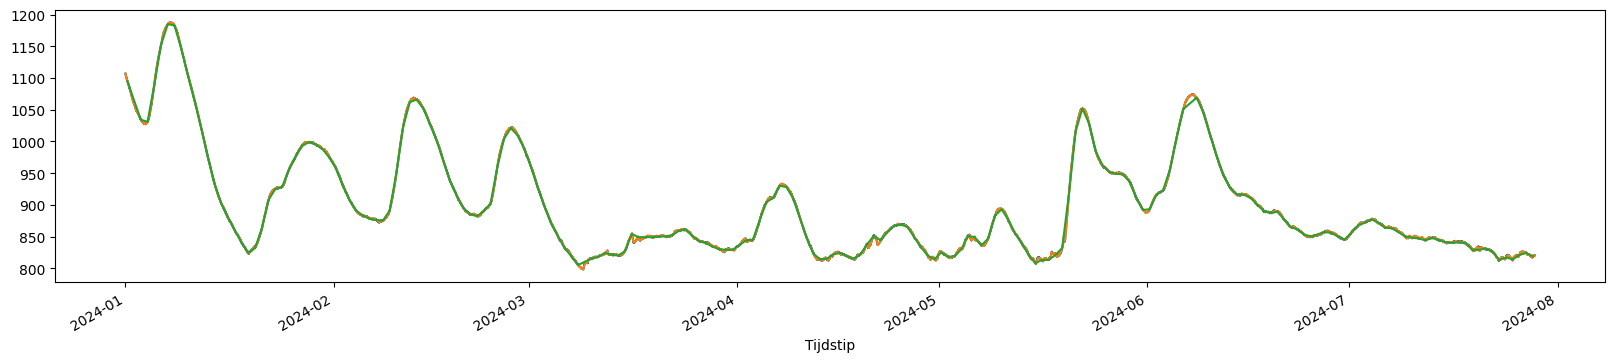

In [9]:
raw_series.plot()
hourly_series.plot()
daily_series.plot()

### Groupby filtering

The second method, which might be the most robust, is using a groupby.

With this method we get a equidistant time in the daily data and it's not missing any important peaks.

In [10]:
grp_daily = raw_series.groupby([raw_series.index.year, raw_series.index.month, raw_series.index.day]).median()
grp_daily.index = map(lambda x: datetime(*x), grp_daily.index.values)
grp_hourly = raw_series.groupby([raw_series.index.year, raw_series.index.month, raw_series.index.day, raw_series.index.hour]).median()
grp_hourly.index = map(lambda x: datetime(*x), grp_hourly.index.values)

In [11]:
pd.Series({
    'Hourly': np.diff(grp_hourly.index).astype(float).std(),
    'Daily': np.diff(grp_daily.index).astype(float).std()
})

Hourly    4.572915e+11
Daily     0.000000e+00
dtype: float64

<Axes: xlabel='Tijdstip'>

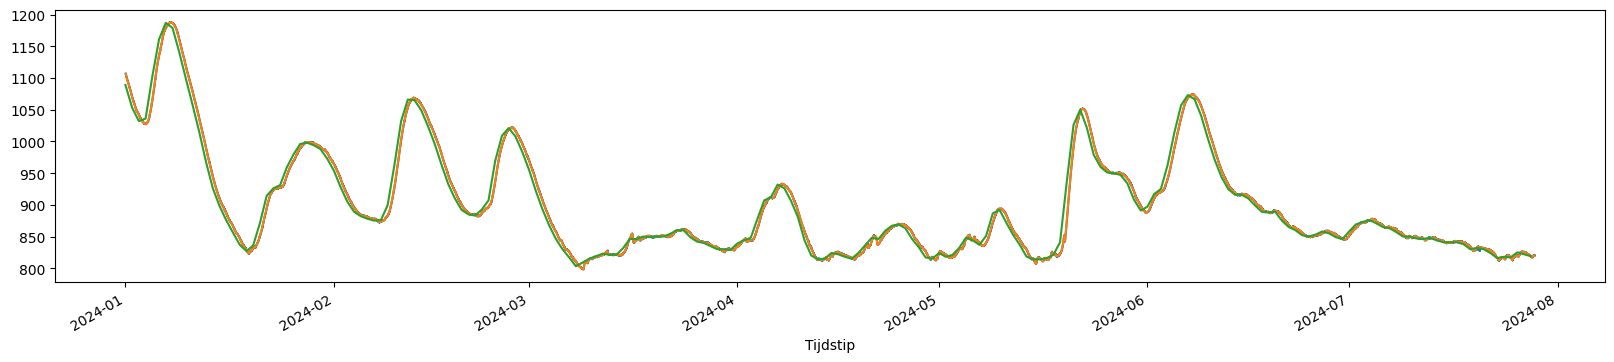

In [12]:
raw_series.plot()
grp_hourly.plot()
grp_daily.plot()

## Weather data

In [13]:
rename = {'temp': 'Temperature', 'tavg': 'Temperature', 'prcp': 'Precipation'}
select = ['Temperature', 'Precipation']
loc_arnhem = Point(51.9800, 5.9111)

we_daily = Daily(loc_arnhem, start, end).fetch().rename(rename, axis=1)[select]

In [14]:
np.diff(we_daily.index).astype(float).std()

np.float64(0.0)

<Axes: xlabel='time'>

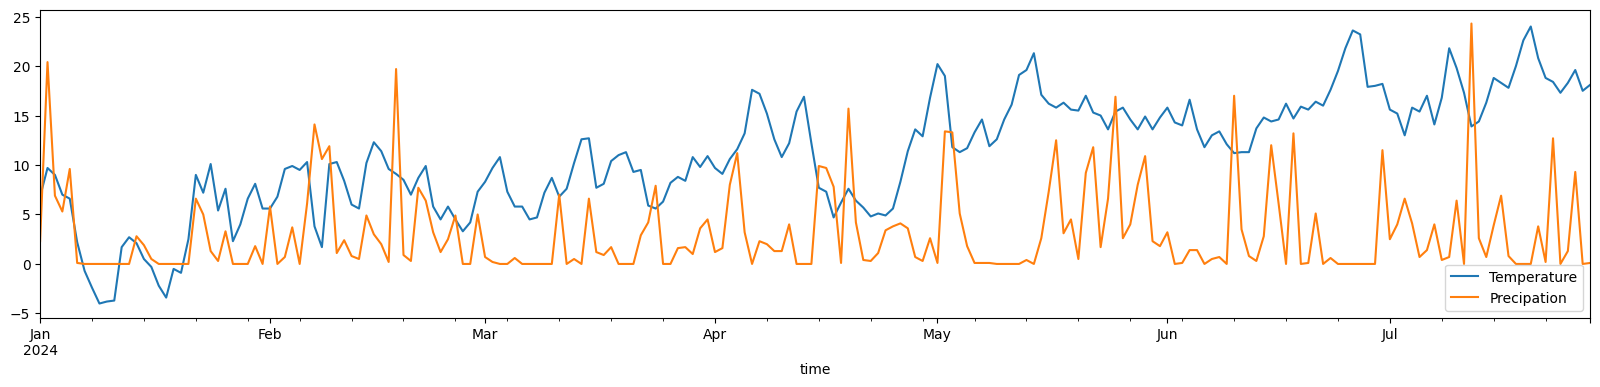

In [15]:
we_daily.plot()

# Combined data

When we combine this data, we already see some slight trends.
For example, as the temperature rises the water levels tends to be less high.
Which is in line with common knowledge about waterlevels on the rhine.

In [16]:
df = pd.concat([grp_daily, we_daily], axis=1).dropna()

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

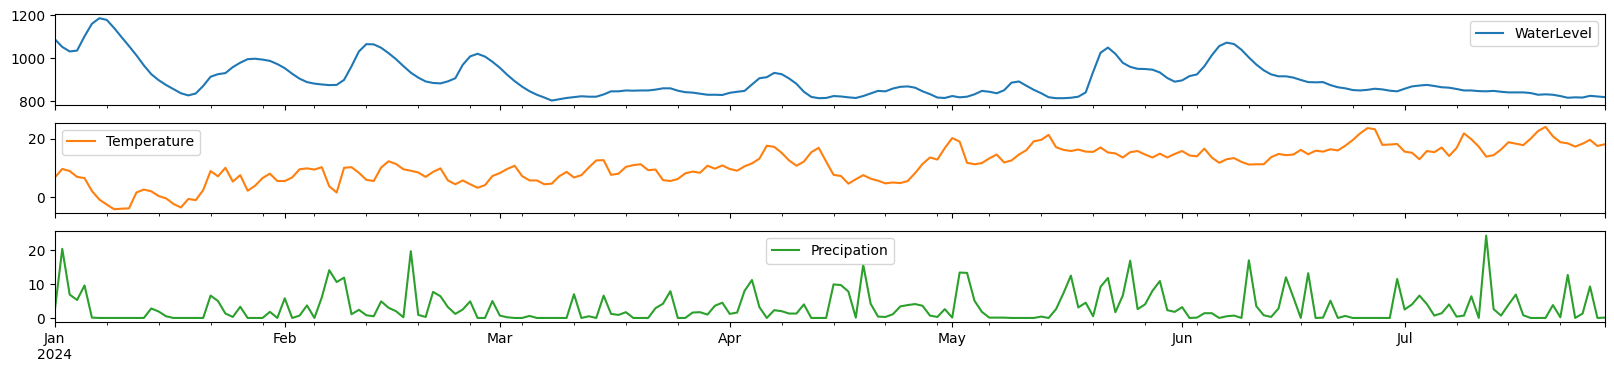

In [17]:
df.plot(subplots=True)

## Analysis

When we dive a little deeper we see that the waterlevel and precipation is similary distributed.
This might indicate a similarity in behavior.

In [18]:
df.describe()

,WaterLevel,Temperature,Precipation
count,210.000000,210.000000,210.000000
mean,898.933333,11.128095,3.127143
std,81.805174,5.855503,4.440330
min,803.000000,-4.000000,0.000000
25%,840.250000,7.050000,0.000000
50%,870.000000,11.300000,1.200000
75%,935.875000,15.600000,4.175000
max,1187.000000,24.000000,24.300000


array([<Axes: ylabel='Density'>, <Axes: ylabel='Density'>,
       <Axes: ylabel='Density'>], dtype=object)

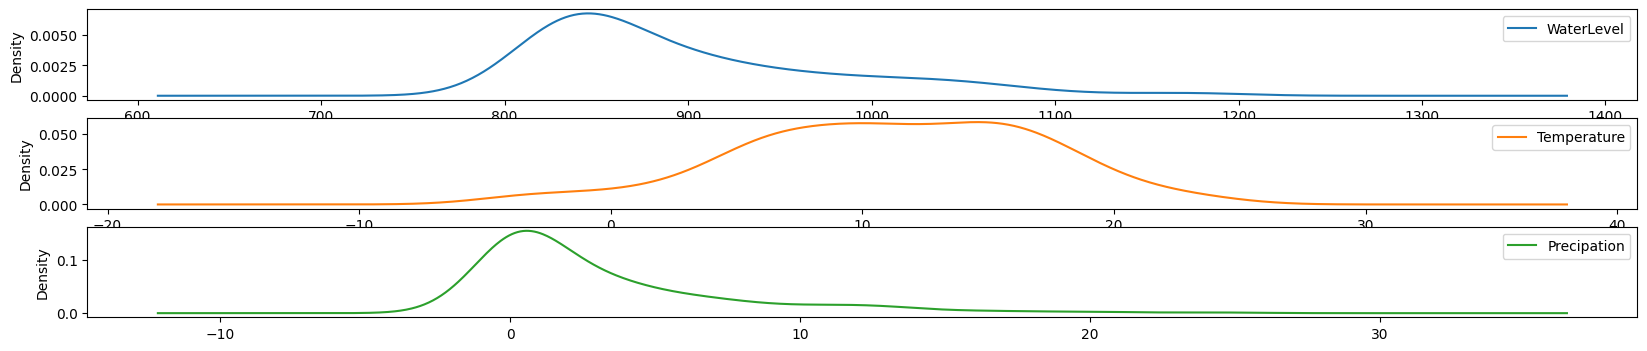

In [19]:
df.plot.density(subplots=True, sharex=False, )

## Correlation

We see that althought the correlation is very low the significance of it is quite high.
Indicating that rain has a very small effect on the waterlevels.
What might be intresting to explore is how much rainfall further upstream might influence the waterlevels.

In [20]:
correlation_significance(df)

WaterLevel           Temperature           Precipation          
            Correlation   P-Value Correlation   P-Value Correlation   P-Value
WaterLevel          1.0       0.0   -0.369787       0.0    0.007526  0.913672
Temperature   -0.369787       0.0         1.0       0.0    0.068293  0.324671
Precipation    0.007526  0.913672    0.068293  0.324671         1.0       0.0

## Most probable maximum

If we then take a look at estimating the the most probable maximum we see that it is seems that weibull estimates the MPM quite well.
We can then use that fit to estimate the 100 year return water level. Which should be somewhere near 1331 cm, since that is highest waterlevel on record. Both overestimate this, but that makes sense since the dataset is very limited.

In [21]:
from scipy.stats import weibull_min, gumbel_r, pareto

wfit = weibull_min.fit(df['WaterLevel'])
gfit = gumbel_r.fit(df['WaterLevel'])

In [22]:
prob = 1/df.shape[0]
weibull_min.isf(prob, *wfit), gumbel_r.isf(prob, *gfit)

(np.float64(1213.5170918040824), np.float64(1154.6332595171802))

In [23]:
p_1y = 1/(100*365)
weibull_min.isf(p_1y, *wfit), gumbel_r.isf(p_1y, *gfit)

(np.float64(1520.7902194861772), np.float64(1435.4692784562403))

# References:

1. https://meteostat.net/en/station/06275?t=2000-01-01/2000-01-31
1. https://www.gelderlander.nl/arnhem/hoogwaterpiek-13-meter~ac9b2371/#:~:text=Het%20is%20voor%20het%20eerst,boven%20NAP%20de%20hoogste%20waterstand.